### **Business IT Alignment Dynamics**  
The proposed model describes how alignment evolves in an organization using the discrete-time equation:  

$$
x_{t + 1} = x_t + A(x_t) - B(x_t)C(x_t)
$$

Where A, B, C are defined as:  
- $ A(x_t) = d(1 - x_t) $
- $ B(x_t) = \frac{a x_t (1 - x_t)^g}{1 + a h x_t} $ 
- $ C(x_t) = \frac{(1 - r)x_t \cdot ((1 - r)x_t)^s}{((1 - r)x_t)^s + (r(1 - x_t))^s} $

#### **Variables and Terms**  
| **Term**       | **Description**                                                                                          | **Key Factors**                                                                 |
|----------------|----------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------|
| **$x_t$**   | Percentage of dissatisfied end users (proxy for misalignment).                                           | State variable representing current alignment level.                           |
| **$A(x_t)$**| **Environmental pressure effect**: Captures how external dynamics (competition, tech obsolescence) increase misalignment. | $d$: Dynamicity of the competitive environment.                              |
| **$B(x_t)$**| **IT department efficacy**: Capacity to translate business needs into IT solutions.                      | $a$: Efficacy of IT department. <br> $h$: Flexibility of IS. <br> $g$: IT investment propensity. |
| **$C(x_t)$**| **Organizational adaptability**: Capacity of the organization to adopt and exploit new IT solutions.     | $r$: Activation threshold for change. <br> $s$: Organizational flexibility. |



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

Let's simulate the evolution of our equation through discrete time steps, where each iteration updates the dissatisfaction level (`x`) based on the parameters given by the user. 

The simulation captures long-term behavior by:
1. Running for a configurable number of steps (50 by default)
2. Enforcing bounds [0,1] via clipping
3. Analyzing the last 10 values to determine system convergence:
   - Stable states (aligned/misaligned/partial)
   - Oscillations between values
   - Chaotic patterns when no clear trend emerges

In [3]:
# Hardcoding the equation 

def A(x, d):
    return d * (1 - x)

def B(x, a, h, g):
    return (a * x * (1 - x)**g) / (1 + a * h * x)

def C(x, r, s):
    term1 = (1 - r) * x
    term2 = r * (1 - x)
    return (term1 * (term1**s)) / (term1**s + term2**s)

def delta(x, d, a, h, g, r, s):
    return A(x, d) - B(x, a, h, g) * C(x, r, s)

In [4]:
def simulate(x0, d, a, h, g, r, s, steps=50):
    x = np.zeros(steps)
    x[0] = x0
    
    for t in range(steps-1):               
        x[t+1] = x[t] + delta(x[t], d, a, h, g, r, s)
        x[t+1] = np.clip(x[t+1], 0, 1)
        
    return x

@interact(
    x0=FloatSlider(min=0, max=1, step=0.01, value=0.5, description='x0'),
    d=FloatSlider(min=0, max=2, step=0.1, value=1.2, description='d'),
    a=FloatSlider(min=0, max=5, step=0.1, value=2.0, description='a'),
    h=FloatSlider(min=0, max=5, step=0.1, value=1.0, description='h'),
    g=FloatSlider(min=0, max=5, step=0.1, value=0.0, description='g'),
    r=FloatSlider(min=0.1, max=0.9, step=0.1, value=0.1, description='r'),
    s=FloatSlider(min=0.5, max=5, step=0.5, value=1.0, description='s'),
    steps=(10, 200, 10)
)
def run_simulation(x0, d, a, h, g, r, s, steps):
    x_values = simulate(x0, d, a, h, g, r, s, steps)
    
    plt.figure(figsize=(12, 5))
    plt.plot(x_values, 'b-o')
    plt.xlabel('Iteration #t')
    plt.ylabel('x (Dissatisfaction)')
    plt.title('Business-IT Alignment Dynamics')
    plt.grid(True)
    plt.ylim(0, 1)
    
    plt.show()
    
    # Analyze long-term behavior
    last_values = x_values[-10:]
    if np.std(last_values) < 0.001:
        final_val = np.mean(last_values)
        if final_val < 0.1:
            print(f"→ System converges to ALIGNED state ({final_val:.3f})")
        elif final_val > 0.9:
            print(f"→ System converges to MISALIGNED state ({final_val:.3f})")
        else:
            print(f"→ System converges to PARTIAL alignment ({final_val:.3f})")
    else:
        if len(np.unique(np.round(last_values, 2))) > 3:
            print("→ Chaotic behavior detected")
        else:
            print("→ System oscillates between states")

interactive(children=(FloatSlider(value=0.5, description='x0', max=1.0, step=0.01), FloatSlider(value=1.2, des…

## Interesting Behaviors:
When `g` is close to zero:
- Bistability (two stable states)
- Critical transitions between aligned/misaligned states

# Phase Portrait

In [8]:
default_params = {
    'd': 0.1, 'a': 0.5, 'h': 0.3, 
    'g': 0.4, 'r': 0.2, 's': 4.0
}

def phase_portait(d, a, h, g, r, s, x_range=(0, 1), n_points=100):
    x = np.linspace(x_range[0], x_range[1], n_points)
    dx = np.array([delta(xi, d, a, h, g, r, s) for xi in x])
    
    plt.figure(figsize=(14, 6))
        
    # Plot 20 arrows evenly spaced for the derivative, letting color represent the intensity. 
    arrow_indices = np.linspace(0, len(x)-1, 20, dtype=int)
    arrow_x = x[arrow_indices]
    arrow_dx = dx[arrow_indices]
    
    norm = Normalize(vmin=0, vmax=np.max(np.abs(dx)))
    cmap = plt.cm.RdYlBu_r
    
    arrow_length = 0.02 
    arrow_head_width = 0.005
    arrow_head_length = 0.008
    arrow_y_pos = 0
    
    for xi, dxi in zip(arrow_x, arrow_dx):
        color = cmap(norm(np.abs(dxi)))
        if dxi > 0:
            plt.arrow(xi, arrow_y_pos, arrow_length, 0, 
                     head_width=arrow_head_width, 
                     head_length=arrow_head_length,
                     fc=color, ec=color, 
                     width=0.0001,
                     length_includes_head=True,
                     alpha=0.9)
        elif dxi < 0:
            plt.arrow(xi, arrow_y_pos, -arrow_length, 0,
                     head_width=arrow_head_width,
                     head_length=arrow_head_length,
                     fc=color, ec=color,
                     width=0.0001,
                     length_includes_head=True,
                     alpha=0.9)
    
    plt.plot(x, dx, 'k-', linewidth=1.5, alpha=0.7, label='dx/dt')
    
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical',
                        pad=0.05, shrink=0.8)
    cbar.set_label('Speed of Change (|dx/dt|)', labelpad=15)
    
    plt.axhline(0, color='black', linewidth=0.5, alpha=0.5)
    plt.xlabel('x (Misalignement)', fontsize=11, labelpad=12)
    plt.ylabel('dx/dt', fontsize=11, labelpad=12)
    plt.title(f'ODE Phase Portrait', fontsize=13, pad=15)
    
    y_max = np.max(np.abs(dx)) * 1.1
    plt.ylim([-y_max, y_max])
    
    plt.grid(True, linestyle=':', alpha=0.3)
    plt.tight_layout()
    plt.show()

@interact(
    d=FloatSlider(min=0, max=1, step=0.01, value=default_params['d'], description='d'),
    a=FloatSlider(min=0, max=10, step=0.1, value=default_params['a'], description='a'),
    h=FloatSlider(min=0, max=2, step=0.1, value=default_params['h'], description='h'),
    g=FloatSlider(min=0, max=5, step=0.1, value=default_params['g'], description='g'),
    r=FloatSlider(min=0, max=0.5, step=0.01, value=default_params['r'], description='r'),
    s=FloatSlider(min=0, max=10, step=0.1, value=default_params['s'], description='s')
)
def update_plot(d, a, h, g, r, s):
    phase_portait(d, a, h, g, r, s)

interactive(children=(FloatSlider(value=0.1, description='d', max=1.0, step=0.01), FloatSlider(value=0.5, desc…

# Chaotic behaviour with logistic map

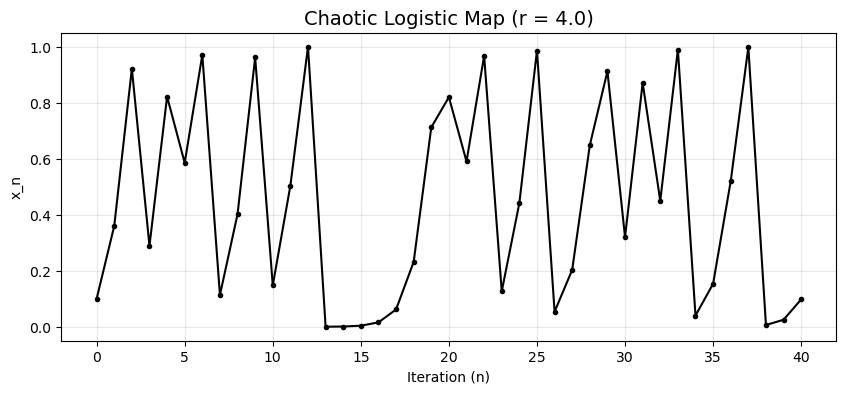

In [42]:
def logistic_map(r, x0, n_iter=1000):
    """Simulate the logistic map: x_{n+1} = r * x_n * (1 - x_n)"""
    x = [x0]
    for _ in range(n_iter):
        x.append(r * x[-1] * (1 - x[-1]))
    return x

# r = 4.0 is fully chaotic
r_chaos = 4.0  
x_chaos = logistic_map(r_chaos, x0=0.1, n_iter=40)

plt.figure(figsize=(10, 4))
plt.plot(x_chaos, 'k.-')
plt.title(f"Chaotic Logistic Map (r = {r_chaos})", fontsize=14)
plt.xlabel("Iteration (n)"); plt.ylabel("x_n")
plt.grid(alpha=0.3)
plt.show()

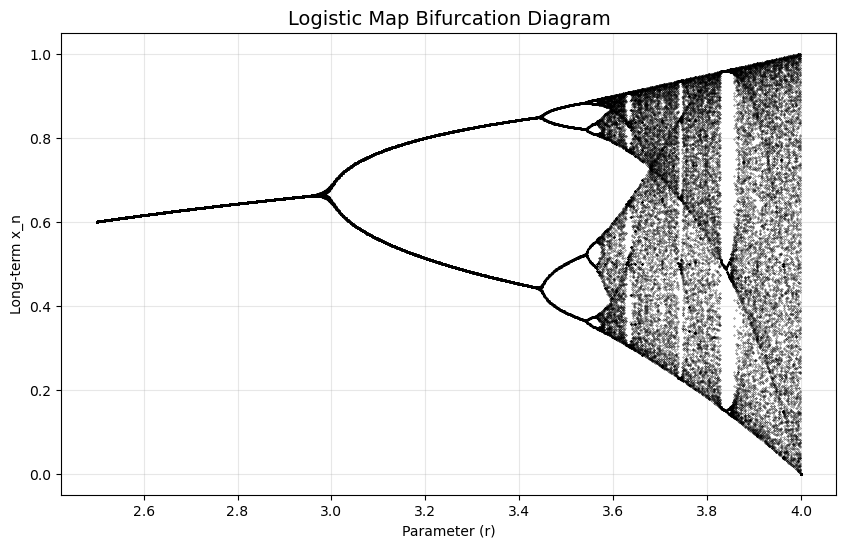

In [43]:
r_values = np.linspace(2.5, 4.0, 1000)
n_last = 100 # Plot last 100 iterations

plt.figure(figsize=(10, 6))
for r in r_values:
    x = 0.5  # Initial condition

    # Don't plot the first 100 iterations
    for _ in range(100):
        x = r * x * (1 - x)
    
    x_vals = []
    
    for _ in range(n_last):
        x = r * x * (1 - x)
        x_vals.append(x)
    plt.plot([r] * n_last, x_vals, 'k.', markersize=0.5)

plt.title("Logistic Map Bifurcation Diagram", fontsize=14)
plt.xlabel("Parameter (r)"); plt.ylabel("Long-term x_n")
plt.grid(alpha=0.3)
plt.show()

# Is my equation chaotic?

In [10]:
default_params = {
    'a': 2.0, 'h': 0.3, 'g': 0.2, 'r': 0.0, 's': 1.0
}

def bifurcation_diagram(a, h, g, r, s):
    d_values = np.linspace(0.5, 2.0, 1000)
    n_last = 100
    n_transient = 200

    plt.figure(figsize=(12, 7))

    for d in d_values:
        x = 0.5
        
        for _ in range(n_transient):
            x = np.clip(x + delta(x, d, a, h, g, r, s), 0, 1)
        
        x_vals = []
        for _ in range(n_last):
            x = np.clip(x + delta(x, d, a, h, g, r, s), 0, 1)
            x_vals.append(x)
        
        plt.plot([d] * len(x_vals), x_vals, 'k.', markersize=0.5, alpha=0.6)

    plt.title(f"Bifurcation Diagram", fontsize=14)
    plt.xlabel("Alignment Pressure (d)", fontsize=12)
    plt.ylabel("Long-term x value", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.savefig('bif_diag.png') # Saving figure
    plt.show()

@interact(
    a=FloatSlider(min=0, max=5, step=0.1, value=default_params['a'], description='a'),
    h=FloatSlider(min=0, max=2, step=0.1, value=default_params['h'], description='h'),
    g=FloatSlider(min=0, max=5, step=0.1, value=default_params['g'], description='g'),
    r=FloatSlider(min=0, max=0.5, step=0.01, value=default_params['r'], description='r'),
    s=FloatSlider(min=0, max=5, step=0.1, value=default_params['s'], description='s')
)
def update_bd(a, h, g, r, s):
    bifurcation_diagram(a, h, g, r, s)

interactive(children=(FloatSlider(value=2.0, description='a', max=5.0), FloatSlider(value=0.3, description='h'…

## TO-DO LIST
- [ ] Study other combinations of inputs.
  - ...
- [ ] Fixed point ($x_{t+1} = x_t$) analysis.  
  - Linearize with the Jacobian.  
  - If $|J| = 1$ it's a bifurcation point.  
- [ ] Study the cut-off region.